# Ultimate-Challenge

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import calendar
import datetime as dt
import missingno as ms

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Part 1 ‑ Exploratory data analysis on LOGINS.

The attached logins file contains (simulated) timestamps of user logins in a particular geographic location.

In [2]:
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


#### We have login data from January-01 to April-13. We are missing 2 weeks of data in the month of April.

## Aggregating login counts on 15-min time intervals.

In [4]:
logins_count = pd.DataFrame(logins.groupby('login_time')['login_time'].count())
logins_count = pd.DataFrame(logins_count['login_time'].resample('15T').count())
logins_count.columns = ['login_time_count_15min']
logins_count = logins_count.reset_index()
logins_count.head()

,login_time,login_time_count_15min
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


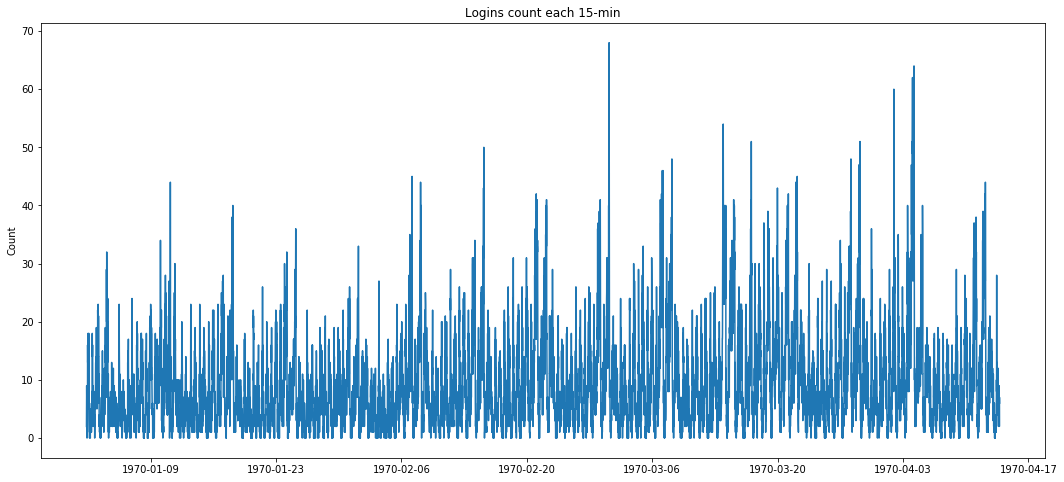

In [5]:
plt.figure(figsize= (18,8))
plt.plot(logins_count['login_time'], logins_count['login_time_count_15min'])
plt.title('Logins count each 15-min')
plt.ylabel('Count')
plt.show()

#### We observe a lot of spikes in the above plot. Let's dig in deeper if we can find any interesting patterns.

## Monthly trend

In [6]:
logins_count_month = pd.DataFrame(logins_count.groupby('login_time')['login_time_count_15min'].sum())
logins_count_month = pd.DataFrame(logins_count_month['login_time_count_15min'].resample('M').sum())
logins_count_month.columns = ['login_time_count']
logins_count_month = logins_count_month.reset_index()
logins_count_month

,login_time,login_time_count
0,1970-01-31,21103
1,1970-02-28,24444
2,1970-03-31,33376
3,1970-04-30,13342


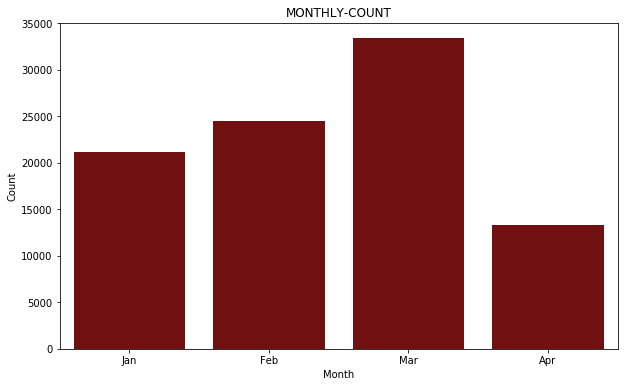

In [7]:
x1 = logins_count_month['login_time'].dt.month.apply(lambda x: calendar.month_abbr[x])

plt.figure(figsize = (10, 6))
sns.barplot(x = x1, y = logins_count_month['login_time_count'], color = 'maroon')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('MONTHLY-COUNT')
plt.show()

#### From the above plots we can observe that number of logins kept increasing and observed maximum login's in the month of March.

## Month-wise time series plot.

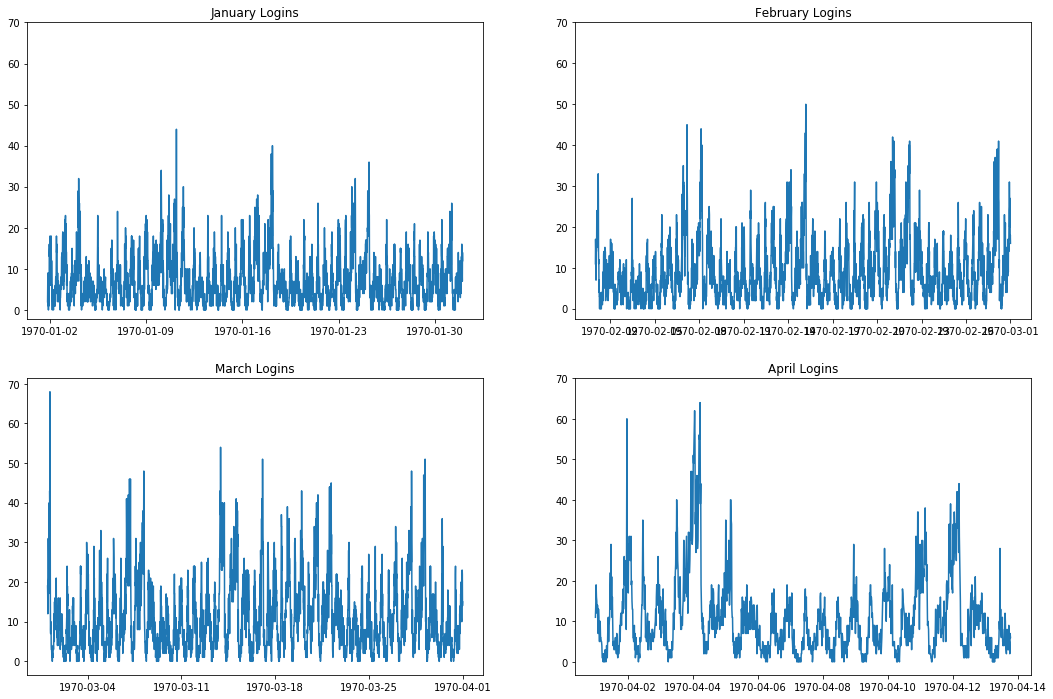

In [8]:
jan = logins_count[(logins_count.login_time > '1970-01') & (logins_count.login_time < '1970-02-01 00:00:01')]
feb = logins_count[(logins_count.login_time > '1970-02') & (logins_count.login_time < '1970-03-01 00:00:01')]
mar = logins_count[(logins_count.login_time > '1970-03') & (logins_count.login_time < '1970-04-01 00:00:01')]
apr = logins_count[(logins_count.login_time > '1970-04') ]

plt.figure(figsize = (18,12))

plt.subplot(221)
plt.plot(jan['login_time'], jan['login_time_count_15min'])
plt.title('January Logins')
plt.yticks(np.arange(0, 71, 10))

plt.subplot(222)
plt.plot(feb['login_time'], feb['login_time_count_15min'])
plt.title('February Logins')
plt.yticks(np.arange(0, 71, 10))

plt.subplot(223)
plt.plot(mar['login_time'], mar['login_time_count_15min'])
plt.title('March Logins')
plt.yticks(np.arange(0, 71, 10))

plt.subplot(224)
plt.plot(apr['login_time'], apr['login_time_count_15min'])
plt.title('April Logins')
plt.yticks(np.arange(0, 71, 10))

plt.show()

#### It seems like there is no clear trend let's dig in and see if we can see anything grouping by week and day of the week.

## Weekly trend.

In [9]:
logins_count_week = pd.DataFrame(logins_count.groupby('login_time')['login_time_count_15min'].sum())
logins_count_week = pd.DataFrame(logins_count_week['login_time_count_15min'].resample('W').sum())
logins_count_week.columns = ['login_time_count']
logins_count_week = logins_count_week.reset_index()
logins_count_week.head(5)


,login_time,login_time_count
0,1970-01-04,2358
1,1970-01-11,5184
2,1970-01-18,4988
3,1970-01-25,4727
4,1970-02-01,4713


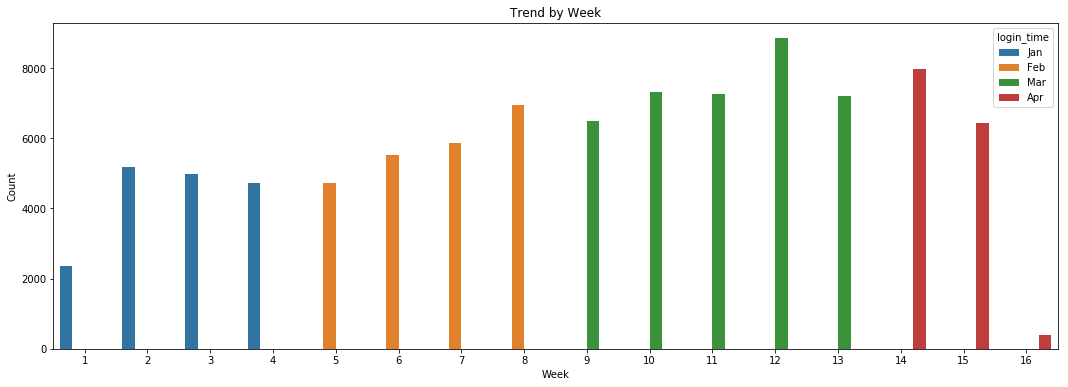

In [10]:
x2 = logins_count_week['login_time'].dt.week
x3 = logins_count_week['login_time'].dt.month.apply(lambda x: calendar.month_abbr[x])

plt.figure(figsize = (18, 6))
sns.barplot(x = x2, y = logins_count_week['login_time_count'], hue = x3)
plt.xlabel('Week')
plt.ylabel('Count')
plt.title('Trend by Week')
plt.show()

#### No clear trend.

## Day of the week trend.

In [11]:
logins_count_day = pd.DataFrame(logins_count.groupby('login_time')['login_time_count_15min'].sum())
logins_count_day = pd.DataFrame(logins_count_day['login_time_count_15min'].resample('D').sum())
logins_count_day.columns = ['login_time_count']
logins_count_day = logins_count_day.reset_index()
logins_count_day.head()

,login_time,login_time_count
0,1970-01-01,112
1,1970-01-02,673
2,1970-01-03,790
3,1970-01-04,783
4,1970-01-05,459


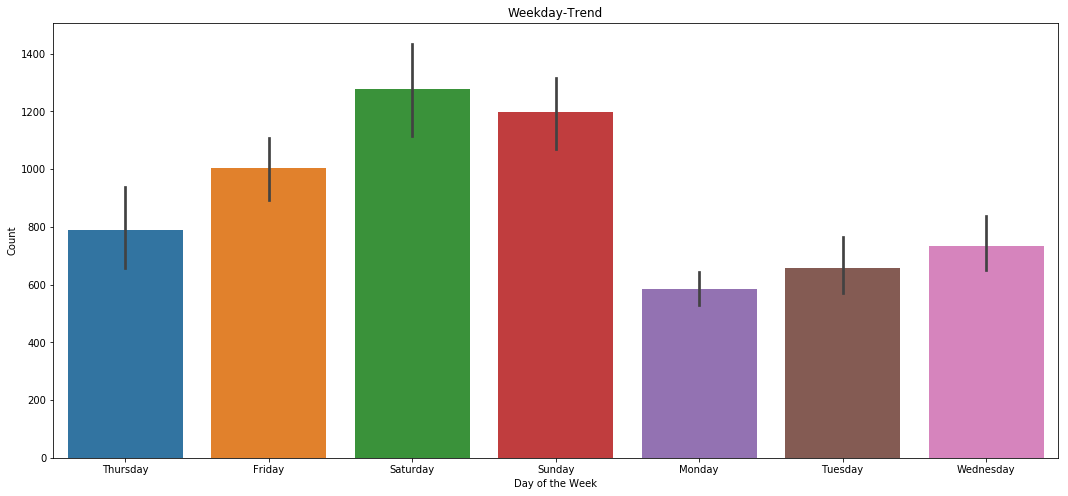

In [12]:
x4 = logins_count_day['login_time'].dt.dayofweek.apply(lambda x: calendar.day_name[x])

plt.figure(figsize = (18, 8))
sns.barplot(x = x4, y = logins_count_day['login_time_count'])
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Weekday-Trend')
plt.show()

#### Here we can wee that the number of login's kept increasing towards the weekend. Now Let's dig in to see if there are any peak hours.

## Hourly trend.

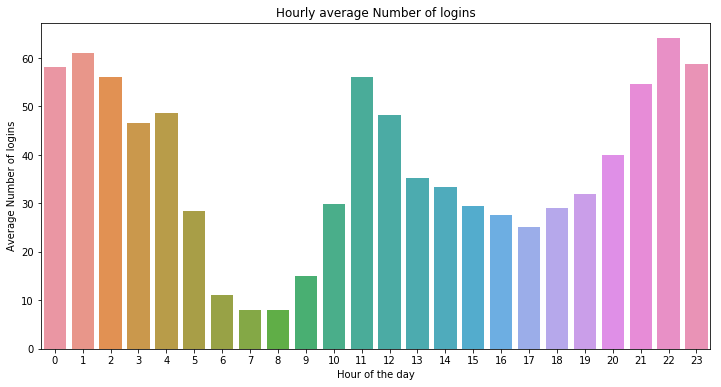

In [13]:
logins_count_hour = pd.DataFrame(logins_count.groupby('login_time')['login_time_count_15min'].sum())
series = logins_count_hour['login_time_count_15min'].resample('H').sum()
avg_logins_count_hour = pd.DataFrame(series.groupby(series.index.hour).mean())
avg_logins_count_hour.columns = ['Avg_hour']
avg_logins_count_hour = avg_logins_count_hour.reset_index()

plt.figure(figsize = (12,6))
sns.barplot(x='login_time', y='Avg_hour', data=avg_logins_count_hour)
plt.xlabel('Hour of the day')
plt.ylabel('Average Number of logins')
plt.title('Hourly average Number of logins')
plt.show()

#### It looks like logins are high during the lunch time between 11AM to Noon and during night time between 9PM to 4PM.

# Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
    a. how you will implement the experiment
    b. what statistical test(s) you will conduct to verify the significance of the
observation
    c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

#### Solution:

Well, to measure the success we have to observe the driving behaviors - Observe toll activity to identify any changes in usage trend.

Also, observe if there are any changes in number of Signup's, average distance travelled by each customer and travelling frequency - How frequently a driver is using the toll way?

We can use license plates or toll-tags to observe the avergage distance and travelling frequency.

By collecting all the above data and observing them we can do statistical tests(t-tests) to see if there is any significant amount of change in the toll activity.

Our Null-hypothesis would be that there is no change in driving behaviors or patterns after the experiment. We can use p-value to test the significance by accepting or rejecting our null hypothesis.



# Part 3 ‑ Predictive modeling

In [14]:
data_2 = pd.DataFrame(json.load(open('ultimate_data_challenge.json')))
data_2.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [15]:
data_2.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [16]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


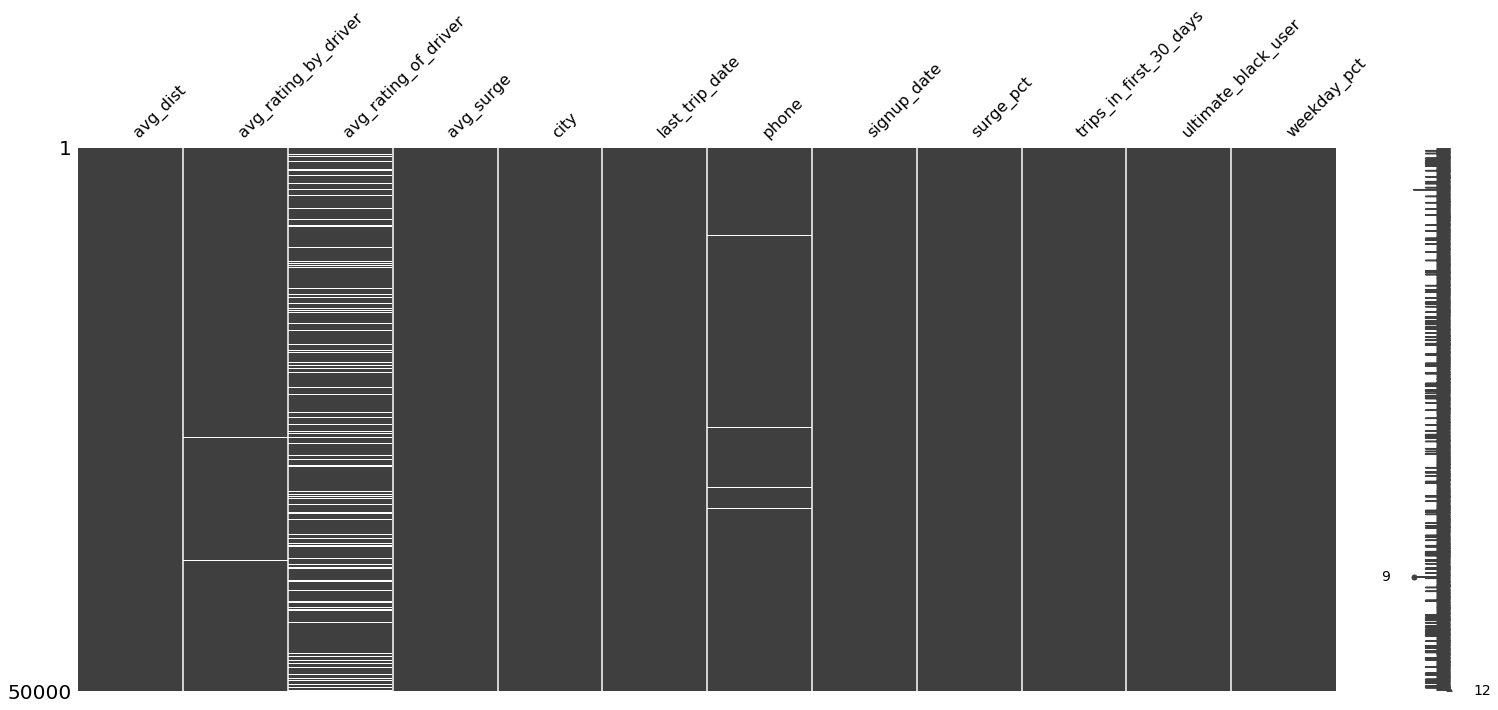

In [17]:
ms.matrix(data_2)
plt.show()

We observe some null values in 'avg_rating_by_driver', 'avg_rating_of_driver' & 'phone' columns.

Since the number of missing values are not much we will impute them by some meaningful statistic.

For the average ratings columns we could use the mean value to replace the missing values with.

For the phone column, because it is a categorical variable we will use mode(most-repeated value) to replace the misssing values.

## Data Cleaning.

### Imputing Missing Values.

In [18]:
data_2['avg_rating_by_driver'].fillna(data_2['avg_rating_by_driver'].mean(), inplace = True)
data_2['avg_rating_of_driver'].fillna(data_2['avg_rating_of_driver'].mean(), inplace = True)
data_2['phone'].fillna('iPhone', inplace = True)

data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     50000 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


### Changing 'last_trip_date' & 'last_trip_date' in to datetime objects.

In [19]:
data_2['last_trip_date'] = pd.to_datetime(data_2['last_trip_date'])
data_2['signup_date'] = pd.to_datetime(data_2['signup_date'])

data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


### Creating Target Variable.

In [20]:
data_2['last_trip_date'].describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In this analysis we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

Here we observe that we have data collected till '2014-07-01'. So we consider all the users who have taken a trip after '2014-06-01' as retained ('1') else ('0'). 

Creating a new column ('retained') in the dataset.

In [21]:
data_2['retained'] = data_2['last_trip_date'].apply(lambda x: 1 if x >= pd.Timestamp('2014-06-01') else 0)

data_2['retained'].value_counts()

0    31196
1    18804
Name: retained, dtype: int64

## Data Exploration.

### Overall Retention Rate

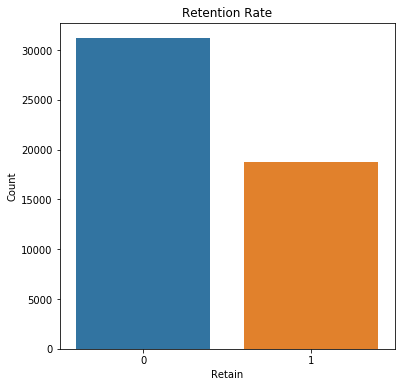

Retention Percentage: 37.608000000000004


In [22]:
plt.figure(figsize=(6,6))

sns.countplot(x="retained", data=data_2)
plt.title('Retention Rate')
plt.xlabel('Retain')
plt.ylabel('Count')
plt.show()
print('Retention Percentage: ' + str(18804/50000 * 100))

We observe that 37.6% customers are retained.

### Average - Distance

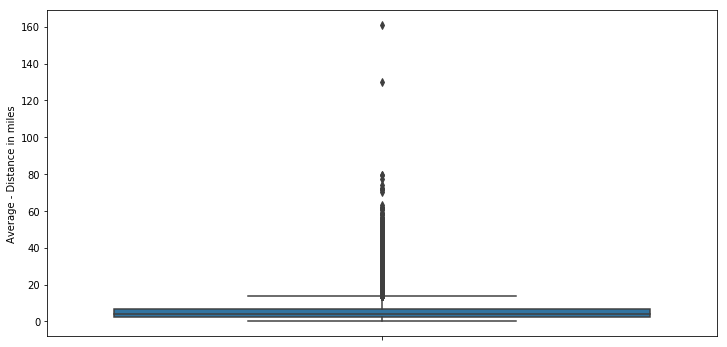

In [23]:
plt.figure(figsize = (12,6))
sns.boxplot(y = data_2.avg_dist, data = data_2)
plt.ylabel('Average - Distance in miles')
plt.show()

Though there seems to be lot of outliers. we're not removing them because it would have a big impact on the dataset.

### Retention rate by City.

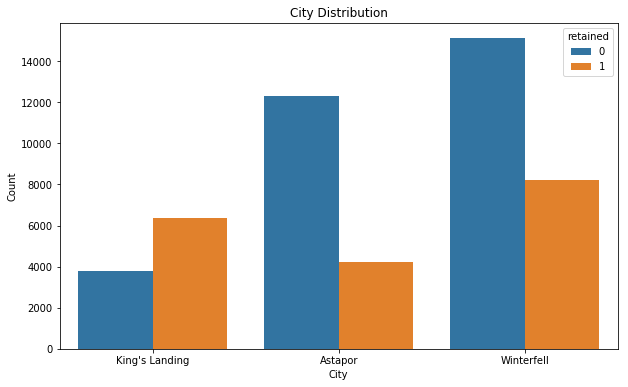

In [24]:
plt.figure(figsize=(10,6))
sns.countplot(x="city", data = data_2, hue = 'retained')
plt.xlabel('City')
plt.ylabel('Count')
plt.title('City Distribution')
plt.show()

We can clearly see that customers from different cities have different retention rates. Customers from 'King's Landing' seems to have high retention rate.

### Retention rate by Phone.

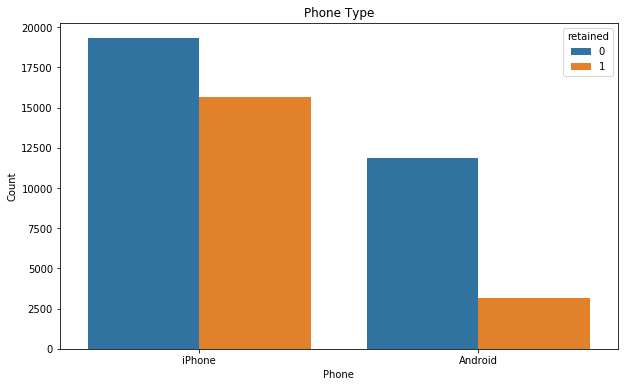

In [25]:
plt.figure(figsize=(10,6))
sns.countplot(x="phone", data = data_2, hue = 'retained')
plt.xlabel('Phone')
plt.ylabel('Count')
plt.title('Phone Type')
plt.show()

Clearly iPhone users have very high retention rate.

### Utimate black users Retention rate

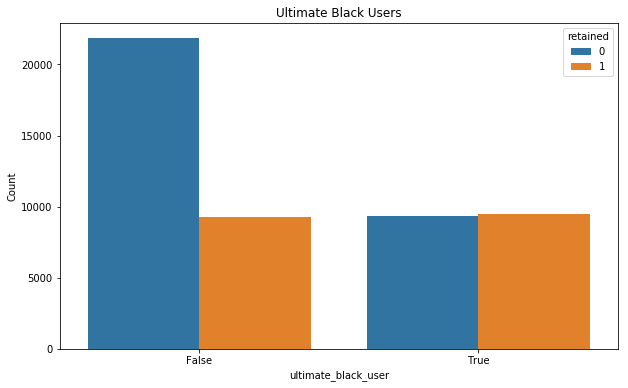

In [26]:
plt.figure(figsize=(10,6))
sns.countplot(x = 'ultimate_black_user', data = data_2, hue = 'retained')
plt.xlabel('ultimate_black_user')
plt.ylabel('Count')
plt.title('Ultimate Black Users')
plt.show()

Ultimate Black Users are more likely to be retained.

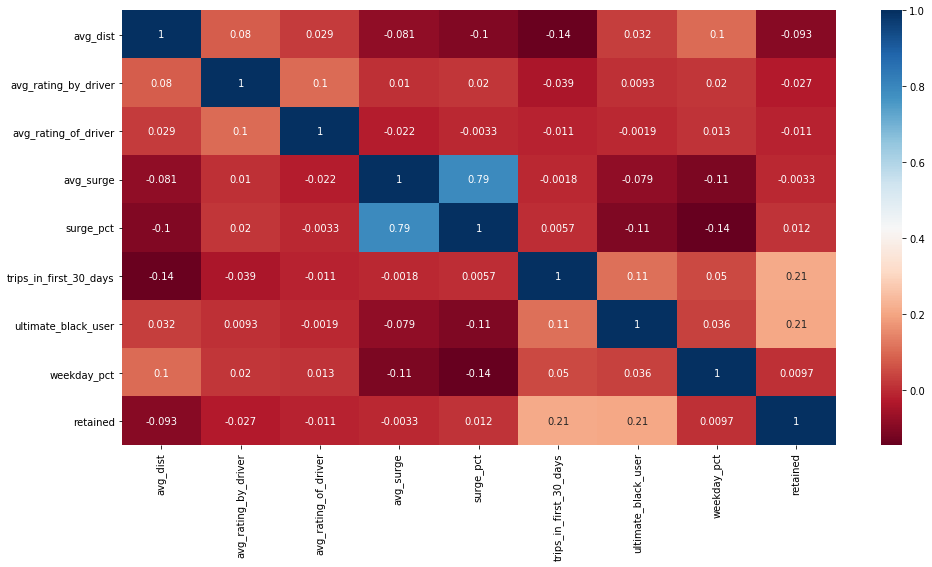

In [27]:
plt.figure(figsize=(16,8))
sns.heatmap(data_2.corr(), cmap = 'RdBu', annot=True)
plt.show()

## Data Pre-Processing.

In [28]:
data_2['signup_date'].describe()

count                   50000
unique                     31
top       2014-01-18 00:00:00
freq                     2948
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object

It is already given that we have been provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. So we're dropping the 'signup_date' column because it doesn't help much.

Also we're dropping 'last_trip_date' because we have created our target variable with a condition (users who have taken a trip after '2014-06-01' as retained ('1') else ('0')) on 'last_trip_date' which might create a bias in prediction.

In [29]:
data_2 = data_2.drop('signup_date', 1)
data_2 = data_2.drop('last_trip_date', 1)

data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
phone                     50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
retained                  50000 non-null int64
dtypes: bool(1), float64(6), int64(2), object(2)
memory usage: 3.9+ MB


In [30]:
data_2 = pd.get_dummies(data_2)

X,y = data_2.drop(['retained'], axis=1), data_2['retained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Model Building.

In [31]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print('Logistic Regression Accuracy : ' + str(accuracy_score(y_test, y_pred_logreg)))

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print('Decision Tree Classifier Accuracy : ' + str(accuracy_score(y_test, y_pred_dt)))

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print('Random Forest Classifier Accuracy : ' + str(accuracy_score(y_test, y_pred_rf)))

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
print('Gradient-Boosting Classifier Accuracy : ' + str(accuracy_score(y_test, y_pred_gbc)))

Logistic Regression Accuracy : 0.7116
Decision Tree Classifier Accuracy : 0.7009
Random Forest Classifier Accuracy : 0.7473
Gradient-Boosting Classifier Accuracy : 0.7809


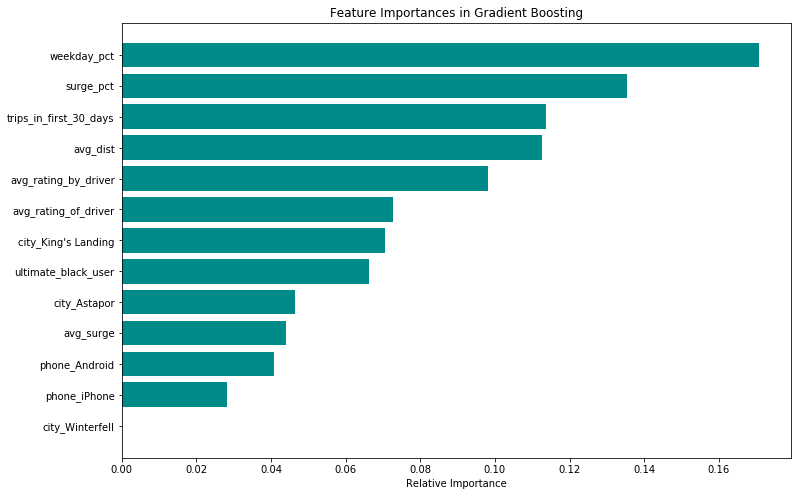

In [32]:
plt.figure(figsize=(12,8))
features = X_train.columns
importances = gbc.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances in Gradient Boosting')
plt.barh(range(len(indices)), importances[indices], color='darkcyan', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

Finally we achieved 78% accuracy with gradient boosting classifier.

From the feature importance plot we observe that out of all the 3 cities, 'King's Landing' tend to have greater probability for retaining. Also customers who are 'ultimate_black_users' tend to be more loyal in terms of retention.
Users who have taken more trips in the first 30 days have more probability to retain. So, may be ultimate can give some offers for new users after they sign up.